In [1]:
import matplotlib.pyplot as plt
import numpy as np
from numba import jit
from numba import cuda
import numba
import time
import multiprocessing as mp
import matplotlib.font_manager as font_manager
import sys
from tqdm import tqdm
import scipy.io as scio

import sys
import numpy as np
import pandas as pd
from scipy.optimize import curve_fit

In [2]:
@jit(nopython = True)
def Degree_generate_homo(node_num, lamb, k_min, k_max, seeds = 10):
    # np.random.seed(seeds)
    degree = np.ones(node_num)
    for i in range(int(node_num)):
        while(True):
            random_degree = np.random.poisson(lamb)
            if((random_degree >= k_min) and (random_degree <= k_max)):
                break           
        degree[i] = int(random_degree)
    return degree

@jit(nopython = True)
def network_generate(K, degree, seeds =10):
    # np.random.seed(seeds)
    n = degree.size
#     p_max = 2*sigma/K
    m = int(np.max(degree))
    index_matrix = np.zeros((n,m))
#     p = np.zeros((n,m))
    degree_clone = np.copy(degree)
    fail_report, fail_report_degree = [], []     ### to double check how many edges do the left nodes have
    for i in range (int(n)):
        temp = []   ### to record the neighbors of nodes
        flag_temp = 0
        while(degree[i]!=0):
            flag = 0
            while(True):
                ram_connect = np.random.randint(degree.size) # 
                flag = flag + 1
#                 print(i, flag, ram_connect, degree[ram_connect])
                if (flag > (1000*degree.size)):
#                     print(i, flag_temp, 'fail')
                    flag = 0
                    fail_report.append(i)
                    break
                if ((ram_connect!= i) and (degree[ram_connect]!= 0) and ((ram_connect not in temp))):
                    break
            if(flag != 0):
                temp.append(ram_connect) 
                flag_temp = flag_temp + 1
                index_matrix[i][int(degree_clone[i] - degree[i])] = ram_connect
                index_matrix[ram_connect][int(degree_clone[ram_connect]-degree[ram_connect])] = i
                degree[i] = degree[i] - 1
                degree[ram_connect] = degree[ram_connect] - 1
            else:
                break
    for j in range(len(fail_report)):
        fail_report_degree.append(degree[int(fail_report[j])])
#     print(fail_report_degree)
    return index_matrix


In [3]:
###   external stimulus   ###
@jit(nopython = True)
def external(t_min, t_max, t, r):
    if t_min < t < t_max:
        return (1 - np.exp(-r))
    else:
        return 0
###   internal(neural) stimulus   ###
@jit(nopython = True)  
def internal(p, index_matrix, index, state_matrix, degree):
    # index here is the neuron at resting state 
    probability = 0
    for i in range (int(degree[index])) :
        if (state_matrix[int(index_matrix[index][i])] == 1): # find the excitable neibour neuron
            probability = 1 - (1 - p[index][i]) * (1 - probability)
    return probability

@jit(nopython = True)
def state_update(r, t, t_min, t_max, p, index_matrix, index,\
                 state_matrix, degree, state_number, temp, random_arr):
    probability = 1 - ((1-external(t_min, t_max, t, r))* \
                        (1 - internal(p, index_matrix, index, state_matrix, degree)))
    if random_arr[index] < probability:
        temp[index] = 1
            
###   determine the activity   ###
@jit(nopython = True)
def rho_determine(state_matrix):
    active = [i for i, v in enumerate(state_matrix) if v==1]
    return len(active)/state_matrix.size

###   determine the average activity   ###
@jit(nopython = True)
def F0_determine(rho, T_min = 0, T_max = 1000):
    return rho[T_min:T_max].sum()/rho[T_min:T_max].size

In [4]:
@jit(nopython = True)
def KC_model(degree, index_matrix, p, t_min, stimulas_t, stimulas_S, MC_times, state_number):
    
    ###   Initialization   ###
    rho = np.zeros(MC_times)
    N = degree.size
    state_matrix = np.random.randint(0, state_number, N)
    temp = np.copy(state_matrix)
    
    ###   Monte Carlo   ###
    for t in range(MC_times):
        
        ###   Update refractory state   ###
        temp[np.where(state_matrix == 0)[0]] -= 1 
        temp[np.where(state_matrix<(state_number-1))] += 1 
        temp[np.where(state_matrix==(state_number-1))] = 0 
        
        ###   Locate the excitable neurons   ###
        zeros = np.where(state_matrix == 0)[0]
        random_arr = np.random.random(N)
        for i in range((zeros.size)):
            state_update(stimulas_S, t, t_min, stimulas_t, p, index_matrix, \
                         zeros[i], state_matrix, degree, state_number, temp, random_arr)
        state_matrix = np.copy(temp)
        rho[t] = rho_determine(state_matrix)
    return rho

In [5]:
def autocorr_range(ts, lag_range):
    ac_array = []
    for lag in lag_range:
        ac_array.append(pd.Series.autocorr(pd.Series(ts), lag))
    return ac_array

def decay_func(x, a, tau, b):
    return a * np.exp(-(x/tau)) + b

def decay(data, lag_max):
    xvar = list(range(lag_max))
    
    popt, pcov = curve_fit(decay_func, xvar, autocorr_range(pd.Series(data), xvar))
    return popt # Return the decay constant

In [6]:
def convert_removing_to_inital(network_connection_removing):
    n,m = network_connection_removing.shape
    # print(n,m)
    index_matrix = np.zeros((n,m))
    for i in range(n):
        row = network_connection_removing[i,:]
        row_ind = row[np.where(row)]
        index_matrix[i,:len(row_ind)] = row_ind
#         print(index_matrix[i,:])
    del_col = []
    for j in range(m):
        col = index_matrix[:,j]
        if not np.any(col):
#             print(j)
            del_col.append(j)
    return np.delete(index_matrix,del_col,1)

def progressive_remove_connections(network_connection1, p1, num_removing_connections):
    # p_value, the propagation rate 
    # the wanted sigma
#     np.random.seed(seeds)  
    N = network_connection1.shape[0]
    network_index1 = np.copy(network_connection1)
    network_index1[np.where(network_index1)] = 1
    
    xys = np.where(network_index1)
    # print(xys)
    xy = [i for i in zip(xys[0],xys[1])] #finding the existing connections
#     print(xy[:5])
    # the number of removing connections
    # num_removing_connections = int(sigma_difference/p_value*N)
#     print(num_removing_connections)
    # the connections will be removed 
    removing_connections = np.random.choice(len(xy), int(num_removing_connections), replace=False)
    # removing
    for i in removing_connections:
        x, y = xy[i]
        network_connection1[x,y] = 0
        
    network_connection2 = convert_removing_to_inital(network_connection1)
    
    network_index2 = np.copy(network_connection2)
    network_index2[np.where(network_index2)] = 1
    network_degree2 = np.sum(network_index2,axis = 1)  
    
    network_p2 = np.copy(network_connection2)
    network_p2[np.where(network_p2 != 0.0)] = p1    
    
    return network_connection2,network_p2,network_degree2
  
def progressive_remove_connections_todegree(network_connection1, p1, k1):
    # p_value, the propagation rate 
    # the wanted sigma
#     np.random.seed(seeds)  
    N = network_connection1.shape[0]
    network_index1 = np.copy(network_connection1)
    network_index1[np.where(network_index)] = 1
    
    korg = round(degree1.sum()/N,2)
    # print('korg is %f' %korg)
    
    xys = np.where(network_index1)
    # print(xys)
    xy = [i for i in zip(xys[0],xys[1])] #finding the existing connections
#     print(xy[:5])
    # the number of removing connections
    num_removing_connections1 = int((korg-k)*N)
    # print(len(xy),num_removing_connections)
    # the connections will be removed 
    removing_connections = np.random.choice(len(xy), num_removing_connections1, replace=False)
    # removing
    for i in removing_connections:
        x, y = xy[i]
        network_connection1[x,y] = 0

    network_connection2 = convert_removing_to_inital(network_connection1)
    
    network_index2 = np.copy(network_connection2)
    network_index2[np.where(network_index2)] = 1
    network_degree2 = np.sum(network_index2,axis = 1) 
    
    network_p2 = np.copy(network_connection2)
    network_p2[np.where(network_p2 != 0.0)] = p1  
    
    return network_connection2,network_p2,network_degree2    


In [7]:
# @jit(nopython = True)
def remove_node_connections_todegree(network_connection, K, avgd = 9 ):
    network_connection_clone = np.copy(network_connection)
    new_mean_degree = K
    
    while new_mean_degree > avgd:
        network_connection = remove_node_connections(network_connection_clone)
        new_degree = new_network_degree(network_connection)
        new_mean_degree = new_degree.mean()
    print(new_mean_degree)
    return  network_connection

# @jit(nopython = True)
def remove_ini_node_and_connections(network_connection1, p_value, ratio = 0.005, seeds = 10): 
    '''
        remove initial nodes and their assicated connections
        ratio should less than 0.005, in order to not affect the sigma
    '''
    
    # np.random.seed(seeds)
    N = network_connection1.shape[0]
    num_of_removed_node = int(ratio*N)
    # print(num_of_removed_node)
    remove_list = np.random.choice(N, size = num_of_removed_node, replace = False)
    # removing the node
    new_network_connection = np.delete(network_connection1, remove_list, axis = 0) 
    # print(new_network_connection.shape)
    # print(new_network_connection)
    # removing the node assicated connections
    for i in remove_list: # removing the node connections
      # new_network_connection[np.where(new_network_connection == i)] = 0
        node_connections_removing = np.where(new_network_connection == i)
        if node_connections_removing[0].size!=0:
            for i,j in list(zip(node_connections_removing[0], node_connections_removing [1])):
                new_network_connection[i,j] = 0
      
    new_network_connection1 = convert_removing_to_inital(new_network_connection)
    # print(new_network_connection1)
    network_p1 = np.copy(new_network_connection1)
    network_p1[np.where(network_p1 != 0.0)] = p_value
    ## degree 
    network_index = np.copy(new_network_connection1)
    network_index[np.where(network_index)] = 1
    network_degree1 = np.sum(network_index,axis = 1)
    # print(network_degree1)
    return new_network_connection1, network_p1, network_degree1

# @jit(nopython = True)
def remove_connections_to_sigma(network_connection, network_p, degree, sigma, p_value = 0.1,  seeds = 10):
    # p_value, the propagation rate 
    # the wanted sigma
    np.random.seed(seeds)
    ini_sigma = round(np.sum(degree)/N)*p_value
    if sigma>ini_sigma:
        raise NameError('the traget sigma should less than initial sigma')
        
    network_index = np.copy(network_connection)
    network_index[np.where(network_index)] = 1
    xys = np.where(network_index)
    # print(xys)
    xy = [i for i in zip(xys[0],xys[1])] #finding the existing connections
#     print(xy[:5])
    # the number of removing connections
    num_removing_connections = int((ini_sigma-sigma)/p_value*N)
#     print(num_removing_connections)
    # the connections will be removed 
    removing_connections = np.random.choice(len(xy), num_removing_connections, replace=False)
    # removing
    for i in removing_connections:
        x, y = xy[i]
        network_index[x,y] = 0
        network_connection[x,y] = 0
        network_p[x,y] = 0
    new_degree = np.sum(network_index,axis = 1)
    return network_connection,network_p,new_degree


In [8]:
def init_network(K, N = 10**5, p_value = 1e-1):    
    # K = 10
    k_min = 2
    k_max = N - 1
    # sigma = 1
    # p_value = 1e-1

    degree = Degree_generate_homo(N, K, k_min, k_max)
    # print(np.max(degree))
    # print(np.random.randint(degree.size))
    # plt.plot(degree)
    degree_clone = degree.copy()
    network_connection = network_generate(K, degree_clone)
    # ## propagation matrix 
    network_p = np.copy(network_connection)
    network_p[np.where(network_p != 0.0)] = p_value
    ## degree 
    network_index = np.copy(network_connection)
    network_index[np.where(network_index)] = 1
    network_degree = np.sum(network_index,axis = 1)
    
    return network_connection, network_degree, network_p

# progressively remove network degree k with fixed p_vlaue
def removing_conn_network(network_connection1, network_degree1, network_p1, p_vlaue = 0.1, times = 1000):
     
    network_connection_clone = np.copy(network_connection1)
    network_degree_clone = np.copy(network_degree1)
    network_p_clone = np.copy(network_p1)
    N = network_connection_clone.shape[0]


    num_removing_connections_each_setp = 0.02*N
    removing_conn = np.arange(0, 0.42, 0.02)
    print(f"==> removing list {removing_conn}")
    
    ###########
    times1 = times
    r = 1/N
    n = 10
    t_test1 = np.arange(times1)
    p_vlaue1 = p_vlaue
    ###########
    rho = []
    sigmas = []
    taus = []
    F0 = []
    
    rho_test = KC_model(network_degree_clone, network_connection_clone, network_p_clone, 0, times1, r, times1, n)
    rho.append(rho_test)
    tau = decay(rho_test[50:],50) #25
    taus.append(tau[1])
    sigmas.append(round(network_degree_clone.sum()/N*p_vlaue1,2))
    F0.append(F0_determine(rho_test))

    j = 0
    while j<len(removing_conn):
        print(f'==> ==> ==> CONN left : {1-(j+1)*0.02} ')
        network_connection3, network_p3, network_degree3 = \
            progressive_remove_connections(network_connection_clone, p_vlaue1,\
                                           num_removing_connections_each_setp)

        network_degree_clone = np.copy(network_degree3)
    #     print(degree_clone)
        network_connection_clone = np.copy(network_connection3)
        network_p_clone = np.copy(network_p3)

        # degrees.append(network_degree)
        rho_test = KC_model(network_degree_clone, network_connection_clone, network_p_clone, 0, times, r, times, n)
        rho.append(rho_test)
        tau = decay(rho_test[50:],25)
        taus.append(tau[1])
        sigmas.append(round(network_degree_clone.sum()/N*p_vlaue1,2))
        
        # print(round(network_degree_clone.mean(),2)*p)
        F0.append(F0_determine(rho_test))

        j = j +1
    return rho,sigmas,taus,F0

# Node removing 

In [19]:
removing_ratio = np.arange(0, 0.16, 0.01)
trails = 50
run = 0
intrinsic = np.zeros((len(removing_ratio),trails))
print(intrinsic.shape)
while run < trails:
    temp = np.zeros(len(removing_ratio))
    for i, ratio in enumerate(removing_ratio):
#         print(i,ratio)
        timeseries = scio.loadmat(f'Aging_network/lag50_new_prediction_var_K10_Timeseries5050_{i+1}_{run+1}.mat')
#         print(timeseries)
        tau = timeseries['intf'][0][0]
        if tau > 180:
            temp = np.zeros(len(removing_ratio))
            break
        temp[i] = tau
    intrinsic[:,run] = temp[:]
#         intrinsic.append(tau)
# #         print(run+1, i+1)
    run = run +1

(16, 50)


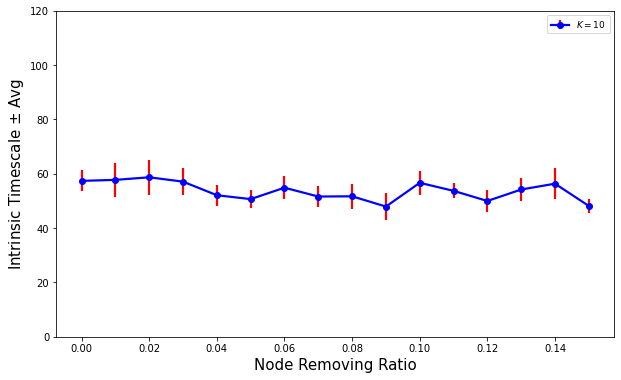

In [22]:
fig, ax = plt.subplots(figsize=(10, 6))
# ax.plot(sorted_ratio,intrinsic2, color='blue', linewidth=2.2, linestyle='-', marker = 'o',label = '$K = %d$'%(10))
ax.errorbar(removing_ratio, mean_intrinsic2, yerr = se, ecolor = 'r', color='blue', linewidth=2.2, linestyle='-', marker = 'o',label = '$K = %d$'%(10))
ax.set_xlabel('Node Removing Ratio',fontsize=15)
ax.set_ylabel('Intrinsic Timescale $\pm$ Avg',fontsize=15)
plt.ylim(0,120)
# ax.set_title('travel frequency vs infected ratio(N = 1000)',fontsize=32)
plt.xticks(fontsize= 10)
plt.yticks(fontsize= 10)
font_prop = font_manager.FontProperties(size=9)
ax.legend(prop = font_prop)
# plt.grid()

In [ ]:
k = 10
times = 5050
N =10**5
r = 1/N
times = 5000
n = 10
# removing_ratio = np.arange(0.01,0.1,0.001)
removing_ratio = np.arange(0,0.16,0.01)
trails = 100
taus = []
run = 0
while run < trails:
    for i, ratio in enumerate(removing_ratio):
#         print(i,N*(1-ratio))
        print(f"====> Node : {int(N*(1-ratio))}")
        network_connection,  network_degree, network_p = init_network(k, N = int(N*(1-ratio)))
    #     print(removing_ratio*N)
        network_degree_clone = np.copy(network_degree)
        #     print(degree_clone)
        network_connection_clone = np.copy(network_connection)
        network_p_clone = np.copy(network_p)
        rho_test = KC_model(network_degree_clone, network_connection_clone, network_p_clone, 0, times, r, times, n)
        tau = decay(rho_test[50:],50)
        taus.append(tau[1])
        F0 = F0_determine(rho_test)
        scio.savemat(f'Aging_network/5050_gmv_rnode_K10_Timeseries_{i+1}_{run+1}.mat',{'rho':rho_test,'intf':tau[1],'F0':F0})
    run= run +1

In [ ]:
k = 10
times = 5050
N =10**5
r = 1/N
times = 5000
n = 10
trails = 100

run = 0
while run < trails:
    network_connection,  network_degree, network_p = init_network(k)
    print('********************************')
    print('Generated network with avaerage degree k = %d '%(k))

    rho,sigmas,taus,F0 = removing_conn_network(network_connection, network_degree, network_p,\
                                        times = times)
    scio.savemat(f'Aging_network/5050_gmv_rnode_K10_Timeseries_{run+1}.mat',{'sigmas':sigmas,'rho':rho,'intf':taus,'F0':F0})
    run= run +1

********************************
Generated network with avaerage degree k = 10 
==> removing list [0.   0.02 0.04 0.06 0.08 0.1  0.12 0.14 0.16 0.18 0.2  0.22 0.24 0.26
 0.28 0.3  0.32 0.34 0.36 0.38 0.4 ]
==> ==> ==> CONN left : 0.98 
==> ==> ==> CONN left : 0.96 
==> ==> ==> CONN left : 0.94 
==> ==> ==> CONN left : 0.92 
==> ==> ==> CONN left : 0.9 
==> ==> ==> CONN left : 0.88 
==> ==> ==> CONN left : 0.86 
==> ==> ==> CONN left : 0.84 
==> ==> ==> CONN left : 0.8200000000000001 
==> ==> ==> CONN left : 0.8 
==> ==> ==> CONN left : 0.78 
==> ==> ==> CONN left : 0.76 
==> ==> ==> CONN left : 0.74 
==> ==> ==> CONN left : 0.72 
==> ==> ==> CONN left : 0.7 
==> ==> ==> CONN left : 0.6799999999999999 
==> ==> ==> CONN left : 0.6599999999999999 
==> ==> ==> CONN left : 0.64 
==> ==> ==> CONN left : 0.62 
==> ==> ==> CONN left : 0.6 
==> ==> ==> CONN left : 0.5800000000000001 
********************************
Generated network with avaerage degree k = 10 
==> removing list [0.   0.02 0.0

In [43]:
trails = 100
run = 0
intrinsic_conn = []
while run < trails:
    timeseries = scio.loadmat(f'Aging_network/5050_gmv_rnode_K10_Timeseries_{ind+1}.mat')
#     print(timeseries[])
#     break
    tau = timeseries['intf'][0]
#     print(np.where(tau > 100)[0])
    if not np.where(tau > 100)[0].size:       
        intrinsic_conn.append(tau)
    run = run +1

In [44]:
intrinsic_conn = np.array(intrinsic_conn)
print(intrinsic_conn.shape)
# intrinsic_conn2  = intrinsic_conn.reshape((-1,trails))
# print(intrinsic2.shape)
mean_intrinsic_conn = np.mean(intrinsic_conn, axis = 0)
print(mean_intrinsic_conn)
conn_std = np.std(intrinsic_conn, axis = 0)
print(conn_std.shape)
print(conn_std.shape)
conn_se = conn_std/np.sqrt(intrinsic_conn.shape[0])
print(conn_se)
# print(se)

(54, 22)
[48.51381857 49.17951333 49.87898309 51.13441994 46.4032284  49.80198864
 48.78451307 46.12612017 43.10370644 42.11895111 41.11735941 35.64008525
 40.58657517 35.79638851 33.47097684 32.9068995  29.50949339 29.8014053
 27.45770096 25.91821912 25.04306411 23.94152984]
(22,)
(22,)
[1.73639515 2.11438781 2.21039933 2.43375024 2.25337675 2.56957175
 2.48042586 2.29833471 2.21834413 1.99915831 2.02525399 1.36746532
 2.11439208 1.61527055 1.59855031 1.4007241  1.45140916 1.38687907
 1.08015362 1.03134901 0.93212194 1.01167999]


# Removing Conn

In [84]:
nsubj = 30
gmv_diff_df = pd.read_csv(f'Aging_network/gmv_diff_df_{nsubj}.csv')
print(gmv_diff_df)
GMV_ratio = gmv_diff_df['GMV_ratio'].values

      Group  GMV_ratio  GMV_nodes
0     Young    0.99921      99921
1     Young    0.99698      99698
2     Young    0.99917      99917
3     Young    0.99733      99733
4     Young    0.99682      99682
5     Young    0.99589      99589
6     Young    0.99966      99966
7     Young    0.99735      99735
8     Young    0.99703      99703
9     Young    0.99925      99925
10    Young    0.99827      99827
11    Young    0.99943      99943
12    Young    0.99972      99972
13    Young    0.99959      99959
14    Young    0.99765      99765
15    Young    0.99959      99959
16    Young    0.99964      99964
17    Young    0.99843      99843
18    Young    0.99682      99682
19    Young    0.99691      99691
20    Young    0.99846      99846
21    Young    0.99905      99905
22    Young    0.99736      99736
23    Young    0.99708      99708
24    Young    0.99940      99940
25    Young    0.99541      99541
26    Young    0.99593      99593
27    Young    0.99736      99736
28    Young   

In [100]:
# sorted_ratio
taus = []
for i, ind in enumerate(sorted_id):
    timeseries = scio.loadmat(f'Aging_network/gmv_rnode/{5050}_gmv_rnode_K10_Timeseries_{ind+1}.mat')
    sigmas = timeseries['sigmas'][0] 
    tau = timeseries['intf'][0]
    if len(tau)!= 41:
        continue
    taus.append(tau)
# print(sigmas,taus)

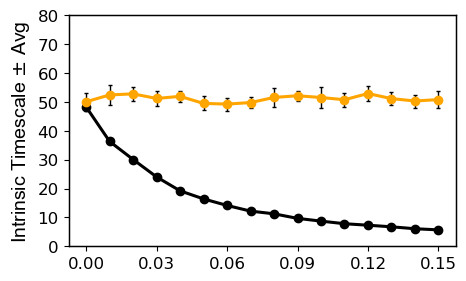

In [310]:
fig, ax = plt.subplots(figsize=(5, 3))
ax.errorbar(removing_connection[:16], conn_mean_tau[:16], yerr = conn_se[:16], color='black',ecolor = 'black', elinewidth = 2, capsize=1,  linewidth=2.2, linestyle='-', marker = 'o',label = '$N = 99795$')
# ax.set_xlabel('Connection Removing Ratio',fontsize=14, family = 'Arial')
ax.set_ylabel('Intrinsic Timescale $\pm$ Avg',fontsize = 14, family = 'Arial')
font_prop = font_manager.FontProperties(size = 12, weight = 4, family = 'Arial')
# plt.xticks([])
plt.xticks(np.arange(0,0.16,0.03),fontsize= 12)
# plt.xticks(removing_connection[:16],fontsize= 12)
plt.yticks(fontsize= 12)

ax2 = ax.twiny()
ax2.errorbar(removing_ratio, mean_intrinsic, yerr = se, ecolor = 'black', color='#FFA500',capsize=1.5,elinewidth = 1, linewidth=2.2, linestyle='-', marker = 'o', label = '$K = %d$'%(10))
# ax2.set_xlabel('Node Removing Ratio',fontsize= 14, family = 'Arial')
ax2.set_ylabel('Intrinsic Timescale $\pm$ Avg',fontsize= 14, family = 'Arial')
plt.ylim(0,80)
# plt.xticks(fontsize= 12)
plt.xticks([])
plt.yticks(fontsize= 12)
plt.savefig(f'variance_prediction4.png', dpi = 400, bbox_inches='tight')
# plt.grid()

bwith = 1. 
ax = plt.gca()
ax.spines['bottom'].set_linewidth(bwith)
ax.spines['left'].set_linewidth(bwith)
# ax.spines['top'].set_visible(False)
# ax.spines['right'].set_visible(False)
ax.spines['top'].set_linewidth(bwith)
ax.spines['right'].set_linewidth(bwith)